[36 数据增广](https://www.bilibili.com/video/BV17y4y1g76q?spm_id_from=333.999.0.0)
- 这里主要讲图片，但实际上图片文本都可以
- <img src="picture\屏幕截图 2022-05-23 225204.png"></a>
- <img src="picture\屏幕截图 2022-05-23 225718.png"></a>
- <img src="picture\屏幕截图 2022-05-23 225943.png"></a>

- 图片数据增强的特点：
    - 一般是在线增强
    - 随机增强，不会是全部增强
    - 测试时候不做增强

- 图片翻转
    - 注意使用场合
    - <img src="picture\屏幕截图 2022-05-23 230141.png"></a>

- 切割
    - 切割完后要恢复大小，避免卷积出错
    - <img src="picture\屏幕截图 2022-05-23 231247.png"></a>
- 颜色
    - <img src="picture\屏幕截图 2022-05-23 231637.png"></a>
- <img src="picture\屏幕截图 2022-05-23 231751.png"></a>



In [8]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

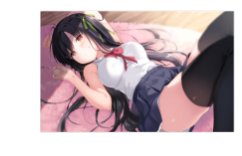

In [15]:
d2l.set_figsize()
img = d2l.Image.open('./picture/test.jpg')
d2l.plt.imshow(img)

In [28]:
def apply(img, aug, num_rows=2, num_cols=2, scale=6):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

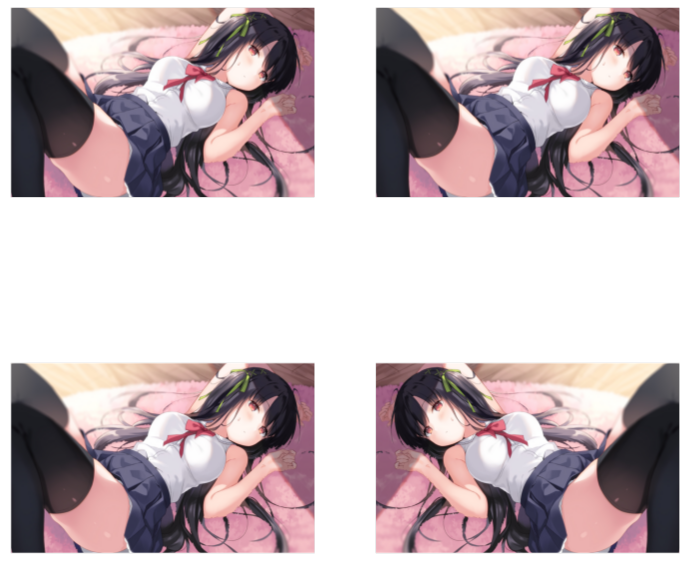

In [29]:
# 随机左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

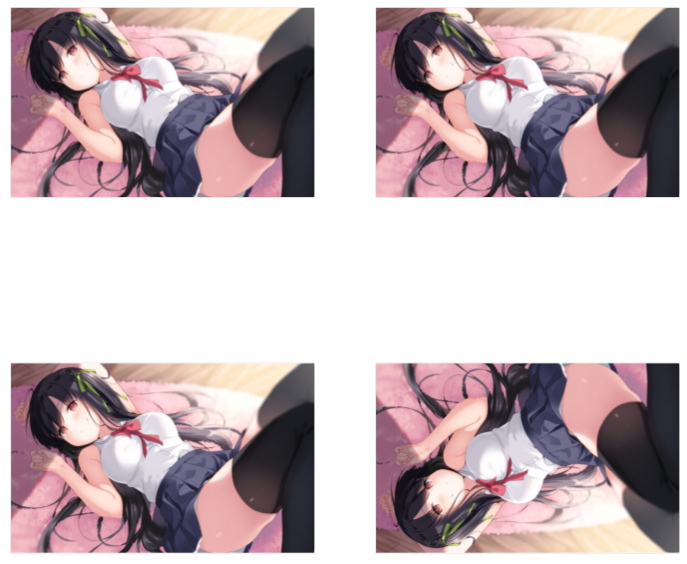

In [30]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

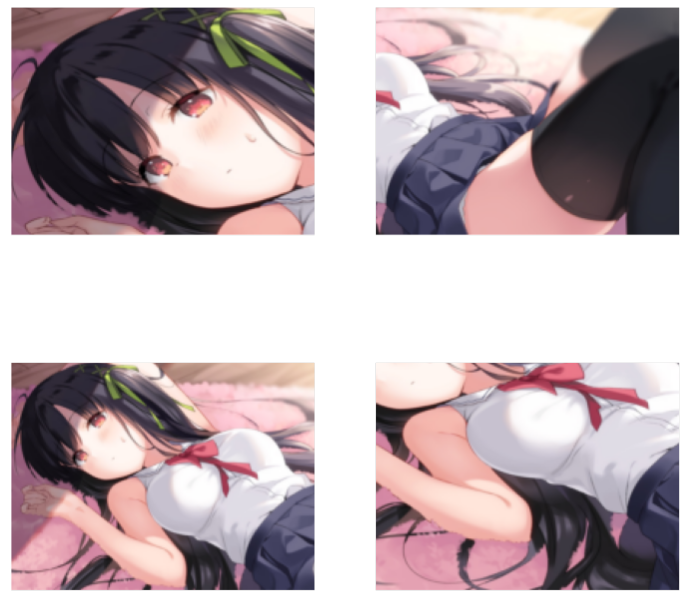

In [75]:
# 随机裁剪
# 效果不错呀
shape_aug = torchvision.transforms.RandomResizedCrop(
    # (150, 200)展示图片大小，scale 裁剪范围占总图片大小，ratio，裁剪区域高宽比
    (150, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

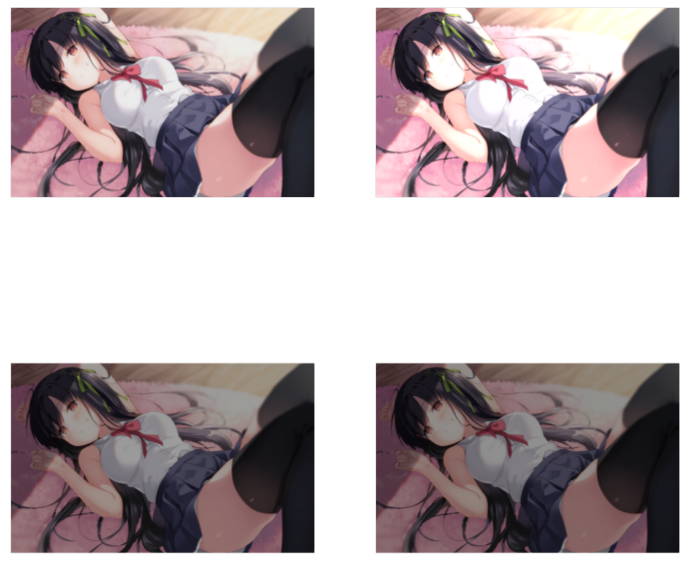

In [76]:
# 随机亮度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

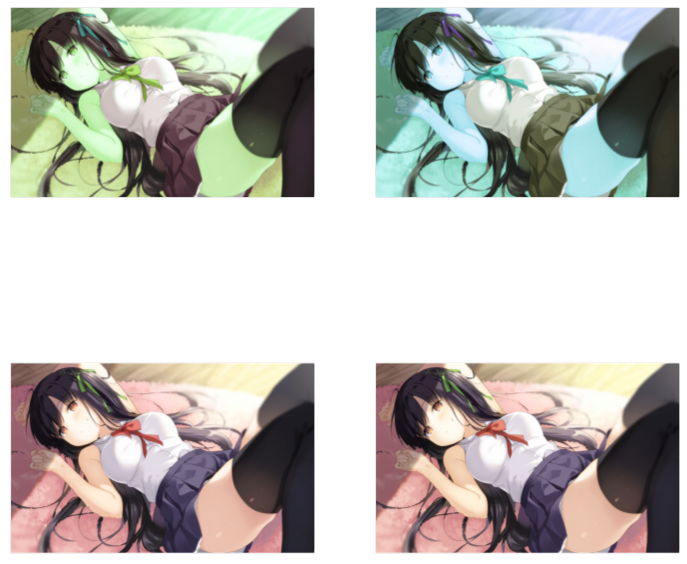

In [77]:
# 随机色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

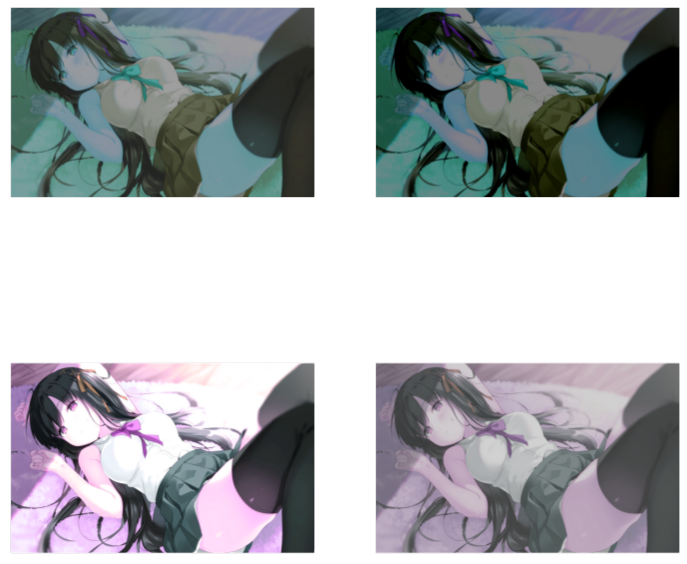

In [78]:
# RandomColorJitter实例，并设置如何同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

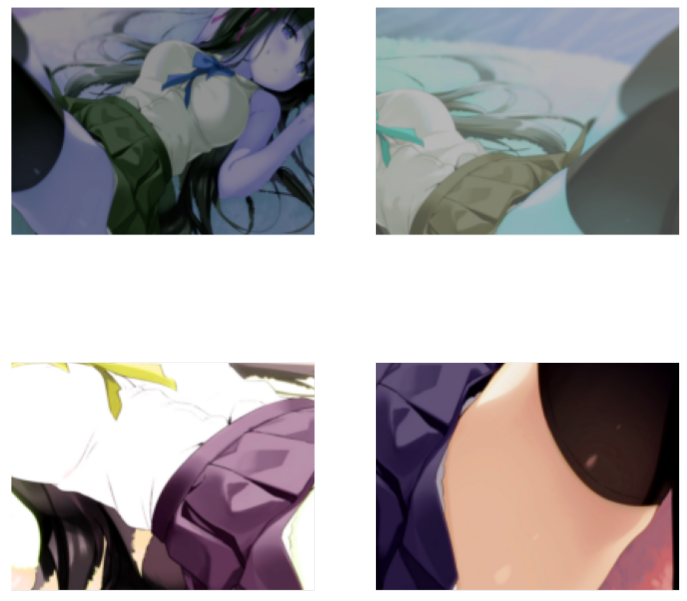

In [79]:
# Compose实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), 
    color_aug, shape_aug])
apply(img, augs)

使用CIFAR-10数据集，而不是之前使用的Fashion-MNIST数据集。 这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。

Files already downloaded and verified


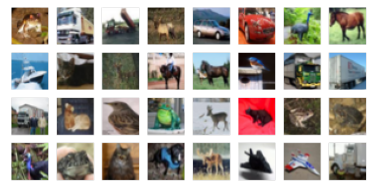

In [83]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。 在这里，我们只使用最简单的随机左右翻转。 此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0到1。

In [84]:
train_augs = torchvision.transforms.Compose([
     # 只做翻转
     torchvision.transforms.RandomHorizontalFlip(),
     # 最后一步转矩阵
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [85]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=4)
    return dataloader

In [86]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    # 多GPU分配
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [87]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.158, train acc 0.946, test acc 0.822
2886.4 examples/sec on [device(type='cuda', index=0)]


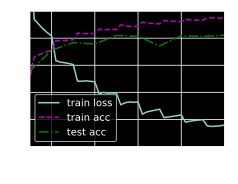

In [88]:
train_with_data_aug(train_augs, test_augs, net)